# INNIO Fleet Analysis

In [8]:
import pandas as pd
pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
import ipywidgets as widgets

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [121]:
def sfun(x):
    return all([
            ("Forsa Hartmoor" in str(x['IB Site Name'])), 
            #("Landshut" in str(x['IB Site Name'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

In [122]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T;

In [123]:
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
display(dl)

Dropdown(description='Engine:', layout=Layout(width='max-content'), options=(('1486144 - Forsa Hartmoor M01', …

In [124]:
rmodes = ['???','OFF','MANUAL','AUTO']; mw = [] ; modes = []
for mm in rmodes:
    mw.append(widgets.Checkbox(value=False, description='Mode: ' + mm))
display(widgets.VBox(mw))


In [13]:
rsucc = [True,False]; sw = []; success=[]
for rs in rsucc:
    sw.append(widgets.Checkbox(value=False, description='Success: ' + str(rs)))
display(widgets.VBox(sw))


In [143]:
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,Forsa Hartmoor M01,M01,AL87,624,H12,24,4582.1,24.5,1486144,159396,188.0,2022-01-10,63,125,0.141


In [144]:
from dfsm import msgFSM
#fsm = msgFSM(e, skip_day=7) #funktioniert nicht
#fsm = msgFSM(e, p_from=motor['Commissioning Date'])
fsm = msgFSM(e)
fsm.run() # run Finite State Machine

fsm_data = []
fsm_data.append({'engine':e, 'fsm':fsm})

Using '9047 target load reached' Message.


FSM: 100%|██████████████████████| 15973/15973 [00:01<00:00, 12921.96 messages/s]


In [145]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
fsm.summary(res)
rdf = res['result']

,From,To,Days,Target Load detection
Interval,27.10.2021,25.02.2022,120,Message '9047 target load reached' .


,Starts,successful,%
???,0,0,0
OFF,11,1,9
MANUAL,92,3,3
AUTO,106,77,72
ALL,209,81,38


In [146]:
modes = [rmodes[i] for i,v in enumerate(mw) if v.value]
modes = rmodes if not modes else modes
success = [rsucc[i] for i,v in enumerate(sw) if v.value]
success = rsucc if not success else success

rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[((rdf['mode'].isin(modes)) & (rdf['success'].isin(success)))].reset_index(drop='index')
print(modes, success)

['???', 'OFF', 'MANUAL', 'AUTO'] [True, False]


In [147]:
# special filters can be added like ... 
rda = rda[((rda['loadramp'] < 80.0) & (rda['startpreparation'] < 300.0))].reset_index(drop='index')

#rda = rda[((rda['count_warnings'] > 0) | (rda['count_alarms'] > 0))].reset_index(drop='index')
# display the filterd & selected data
rda[fsm.filter_content + ['count_alarms', 'count_warnings']].round(2)

,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,targetoperation,count_alarms,count_warnings
0,False,MANUAL,103.14,4.24,22.80,20.10,40.47,53.98,244.72,NaT,0,3
1,False,MANUAL,67.79,4.23,18.17,5.76,45.21,69.90,211.06,NaT,2,2
2,False,MANUAL,71.22,4.04,18.05,16.05,39.61,79.62,228.59,NaT,0,0
3,False,MANUAL,116.91,4.24,21.99,49.76,21.09,43.52,257.52,NaT,1,0
4,True,AUTO,60.53,3.53,19.28,5.35,35.52,58.15,182.36,0 days 03:02:00,0,2
5,False,MANUAL,135.90,3.74,19.88,5.96,51.93,76.54,293.94,NaT,1,0
6,True,AUTO,98.39,3.73,24.13,6.57,66.38,57.91,257.11,0 days 03:41:41,0,1
7,True,AUTO,69.26,4.24,25.03,6.26,55.08,70.96,230.82,0 days 00:16:48,0,1
8,True,AUTO,87.88,3.94,18.76,4.14,95.90,66.25,276.88,0 days 01:33:30,0,0


In [148]:
startversuch = rda.iloc[0];
von_dt=pd.to_datetime(startversuch['starttime']); von=int(von_dt.timestamp() - fsm._pre_period)
bis_dt=pd.to_datetime(startversuch['endtime']); bis=int(bis_dt.timestamp())
cycle = 1 #sec.
data = fsm.get_period_data(von, bis, cycletime=cycle)
ftitle = f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
print(f"von:{von_dt} = {von} bis:{bis_dt} = {bis}")

Load Data: 50000 datarows [00:00, 257106.64 datarows/s]                         


von:2021-11-19 09:01:04.264000 = 1637312464 bis:2021-11-19 09:05:08.983000064 = 1637312708


In [132]:
# dset = [
#     {'col':['Power_PowerAct'], 'ylim':(0,5000)},
#     {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500]}
# ]
# dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(10,6))

In [149]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct','test'], 'ylim':(0,5000)}
]
data = fsm.get_cycle_data(startversuch, max_length=600, min_length=300, cycletime=1)

Load Data: 50000 datarows [00:00, 245820.88 datarows/s]                         


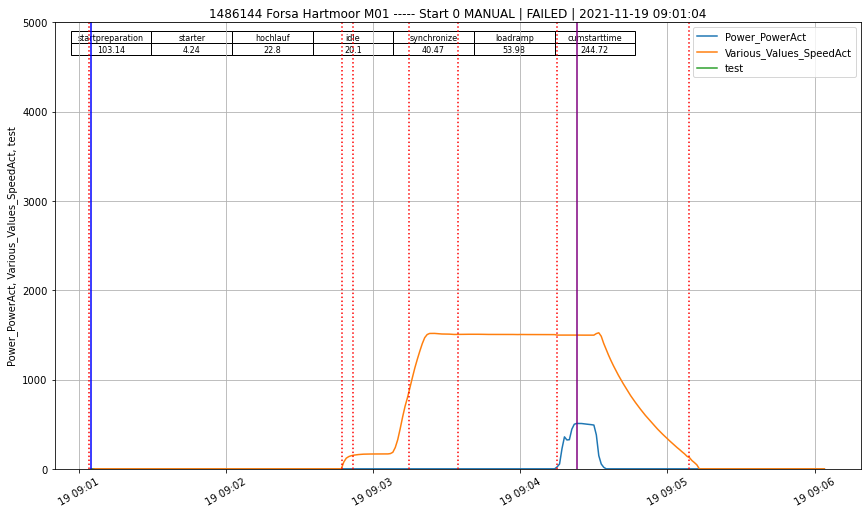

In [150]:
x0 = data.iloc[0]['datetime'];x1 = data.iloc[-1]['datetime']
data['test'] = data['Power_PowerAct']+(data['datetime'] - x0)*(-2000.0)/(x1-x0) + 0.0
#ax, ax2, idf = dmyplant2._plot(data, style='.-', figsize=(18,10), title=ftitle);
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)

sv_lines = startversuch[fsm.vertical_lines_times]
lines = [sv_lines[:i+1].sum() for i,v in enumerate(sv_lines) if v==v]
start = startversuch['starttime']
dmyplant2.add_lines(start, lines, ax, color='red', linestyle="dotted")

p = data.loc[data['Power_PowerAct'].idxmax()]
dmyplant2.add_lines(p.datetime, [], ax, color='purple', linestyle="-")

p = data.loc[data['test'].idxmax()]
dmyplant2.add_lines(p.datetime, [], ax, color='blue', linestyle="-")

summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
dmyplant2.add_table(summary, ax, loc='upper left')


plt.show()

Load Data: 50000 datarows [00:00, 196537.74 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime
0,103.14,4.24,22.8,20.1,40.47,53.98,244.72


startpreparation 000000 700 1637312466586 19.11.2021 09:01:06  1195 Safety slam shut valve status signal failure
loadramp         000001 700 1637312671155 19.11.2021 09:04:31  1189 Release from synchronizing missing
loadramp         000002 700 1637312671155 19.11.2021 09:04:31  1175 Mains failure


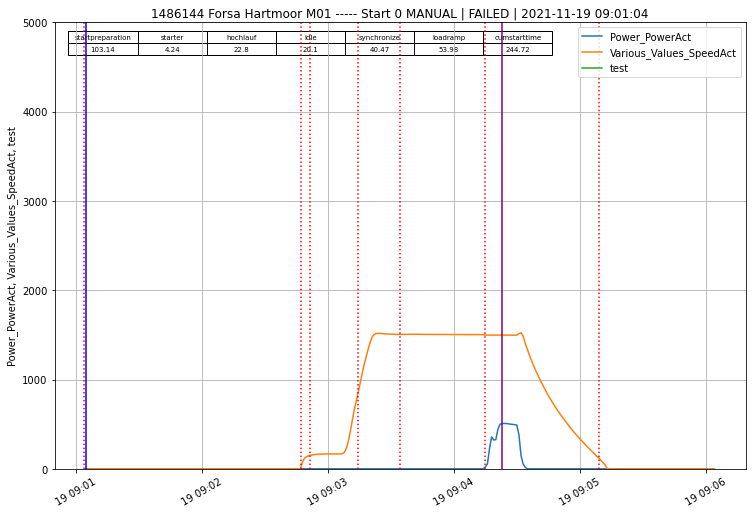

Load Data: 50000 datarows [00:00, 196089.89 datarows/s]                         

loadramp         000000 800 1637313396595 19.11.2021 09:16:36  1134 Ground fault generator
loadramp         000001 800 1637313396595 19.11.2021 09:16:36  1036 Generator overload/short circuit


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime
1,67.79,4.23,18.17,5.76,45.21,69.9,211.06


hochlauf         000000 700 1637313315093 19.11.2021 09:15:15  2476 CAM/Reset pickup signal deviation during engine operation
loadramp         000001 700 1637313396595 19.11.2021 09:16:36  3412 Mains monitoring device failure / generator protection relay failure


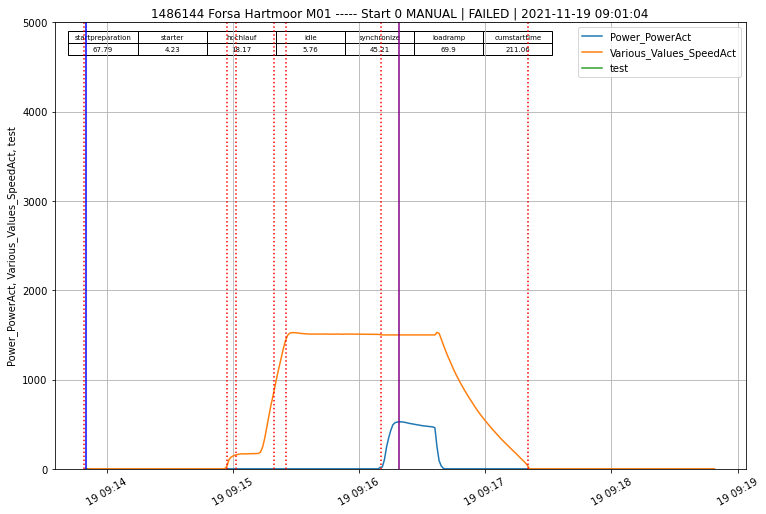

Load Data: 50000 datarows [00:00, 132034.78 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime
2,71.22,4.04,18.05,16.05,39.61,79.62,228.59


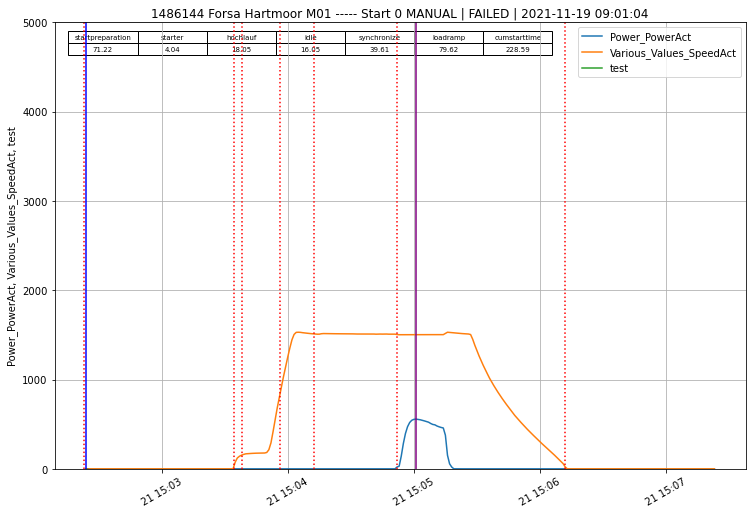

Load Data: 50000 datarows [00:00, 253947.53 datarows/s]                         


loadramp         000000 800 1637575167766 22.11.2021 09:59:27  1132 Differential protection


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime
3,116.91,4.24,21.99,49.76,21.09,43.52,257.52


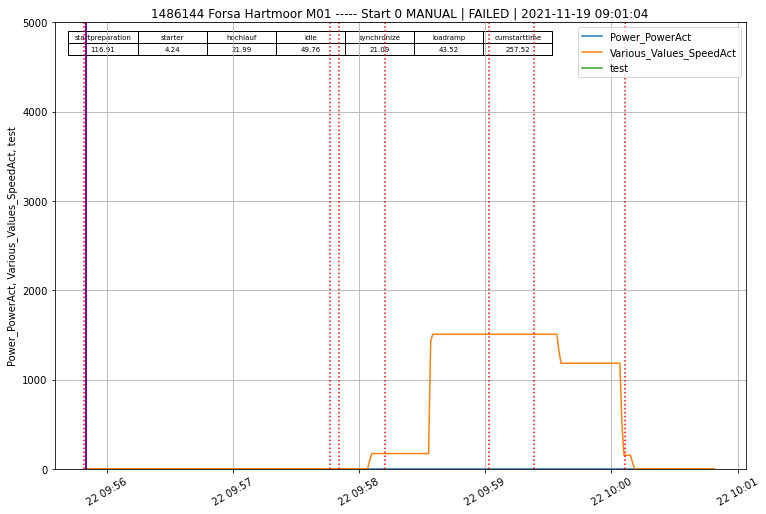

Load Data: 50000 datarows [00:00, 167774.44 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime
4,60.53,3.53,19.28,5.35,35.52,58.15,182.36


targetoperation  000000 700 1637855200979 25.11.2021 15:46:40  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000001 700 1637855499028 25.11.2021 15:51:39  3562 Charge temperature minimum


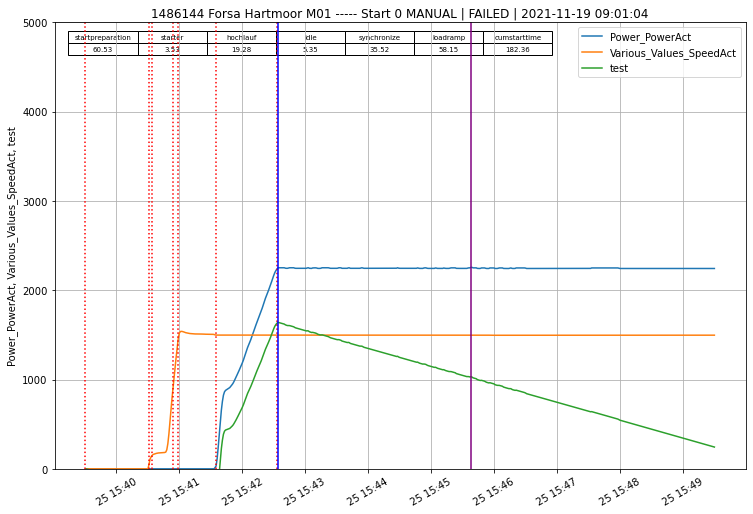

Load Data: 50000 datarows [00:00, 164200.86 datarows/s]                         

loadramp         000000 800 1638293741421 30.11.2021 17:35:41  1132 Differential protection


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime
5,135.9,3.74,19.88,5.96,51.93,76.54,293.94


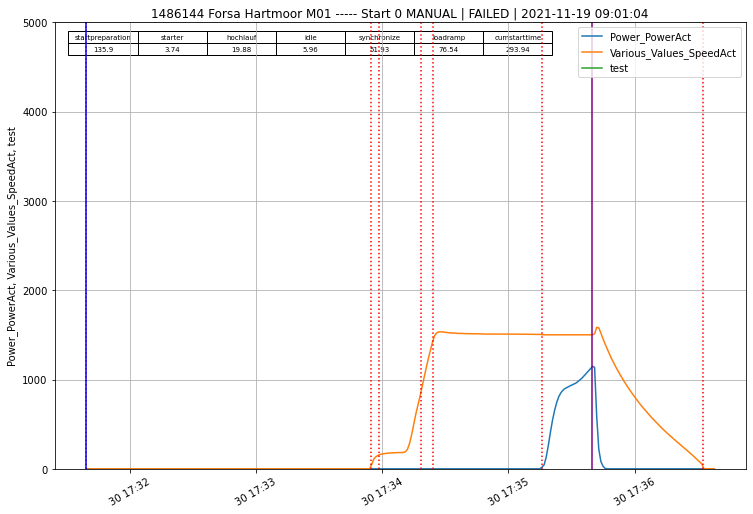

Load Data: 50000 datarows [00:00, 260028.02 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime
6,98.39,3.73,24.13,6.57,66.38,57.91,257.11


targetoperation  000000 700 1640249804247 23.12.2021 08:56:44  2531 Charge temperature before high-pressure turbocharger minimum


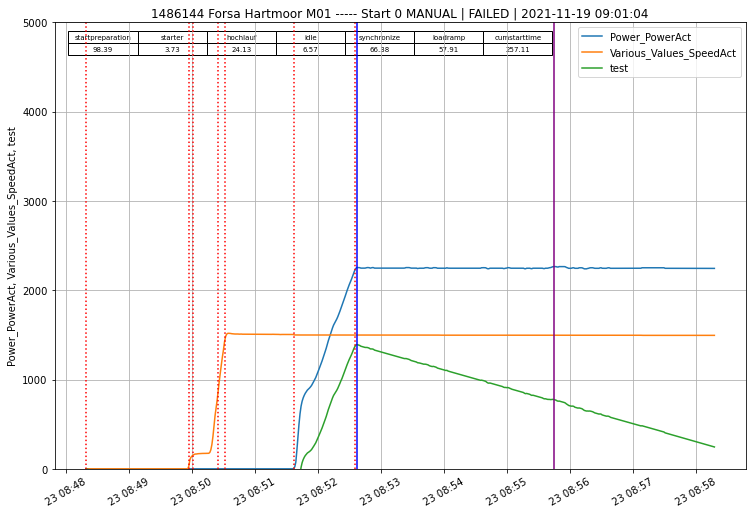

Load Data: 50000 datarows [00:00, 240839.63 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime
7,69.26,4.24,25.03,6.26,55.08,70.96,230.82


targetoperation  000000 700 1641497078611 06.01.2022 19:24:38  2531 Charge temperature before high-pressure turbocharger minimum


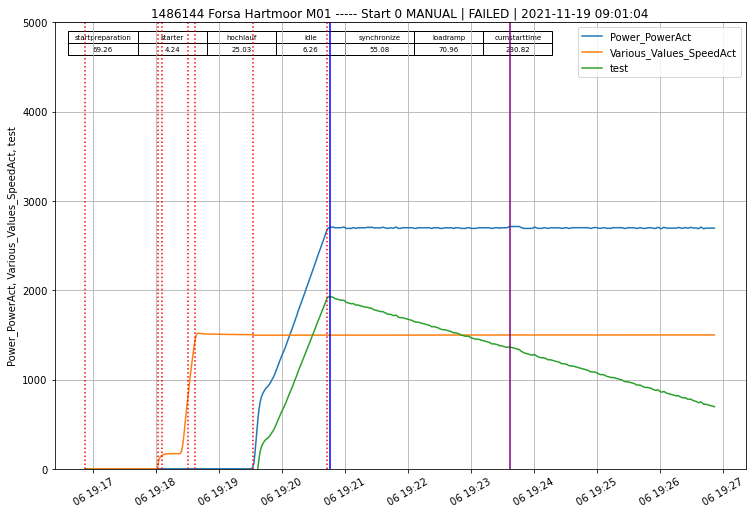

Load Data: 50000 datarows [00:00, 179682.99 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime
8,87.88,3.94,18.76,4.14,95.9,66.25,276.88


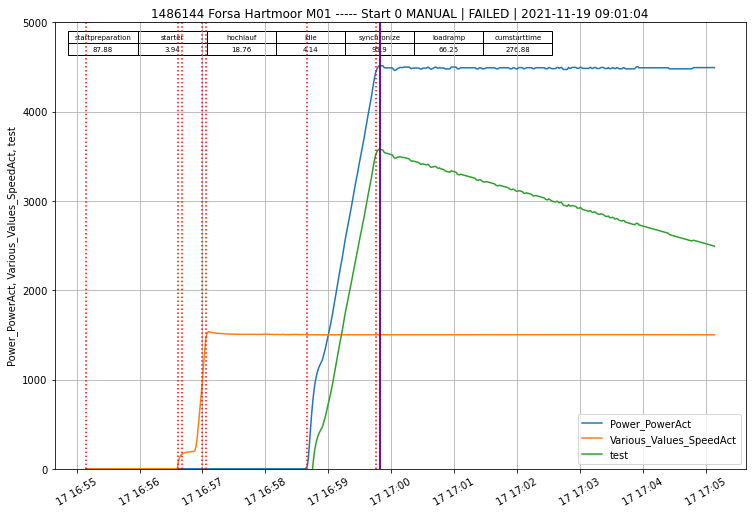

In [151]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct','test'], 'ylim':(0,5000)}
]
for ii,startversuch in rda.iterrows():
        if ii < 0:
                continue
        if ii > 150:
                break
        data = fsm.get_cycle_data(startversuch, max_length=600, min_length=300, cycletime=1)
        #ax, ax2, idf = dmyplant2._plot(data, style='.-', figsize=(18,10), title=ftitle);
        x0 = data.iloc[0]['datetime'];x1 = data.iloc[-1]['datetime']
        data['test'] = data['Power_PowerAct']+(data['datetime'] - x0)*(-1000.0)/(x1-x0) + 0.0

        fig, ax, axes = dmyplant2.chart(data, dset, figsize=(12,8), title=ftitle)

        sv_lines = startversuch[fsm.vertical_lines_times]
        lines = [sv_lines[:i+1].sum() for i,v in enumerate(sv_lines) if v==v]
        start = startversuch['starttime']
        dmyplant2.add_lines(start, lines, ax, color='red', linestyle="dotted")

        p = data.loc[data['test'].idxmax()]
        dmyplant2.add_lines(p.datetime, [], ax, color='blue', linestyle="-")

        p = data.loc[data['Power_PowerAct'].idxmax()]
        dmyplant2.add_lines(p.datetime, [], ax, color='purple', linestyle="-")

        summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
        dmyplant2.add_table(summary, ax, loc='upper left')
        for i, al in enumerate(startversuch['alarms']):
                print(f"{al['state']:16} {fsm.msgtxt(al['msg'],i)}")

        display(HTML(summary.to_html(escape=False)))
        for i, w in enumerate(startversuch['warnings']):
                print(f"{w['state']:16} {fsm.msgtxt(w['msg'],i)}")
        #fsm.plot_cycle(startversuch, max_length=600, ylim=(0,2500), cycletime=1, style='.-', figsize=(10,6), 
        #    title=f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}");
        plt.show();

In [37]:
rda.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
cumstarttime,700.0,451.9,42.0,344.2,440.4,446.7,451.3,969.0
startpreparation,700.0,261.8,27.2,162.3,261.8,262.8,263.5,785.5
starter,700.0,5.2,2.2,3.8,4.5,4.8,5.3,44.4
hochlauf,700.0,16.6,2.4,12.2,15.0,15.9,17.7,29.3
idle,700.0,13.5,31.0,5.9,6.8,7.7,8.3,261.8
synchronize,700.0,15.8,7.5,0.4,9.8,16.4,19.3,56.2
loadramp,700.0,138.9,0.0,138.9,138.9,138.9,138.9,138.9
targetoperation,700,0 days 22:02:15.242857142,1 days 21:48:07.011423411,0 days 00:00:28,0 days 00:54:50,0 days 03:45:29.500000,0 days 20:19:08.500000,18 days 19:19:13
count_alarms,700.0,0.4,0.8,0.0,0.0,0.0,1.0,6.0
count_warnings,700.0,4.9,5.5,0.0,2.0,3.0,6.0,65.0


In [42]:
longer_than_300s = rda[fsm.filter_period + fsm.filter_content][rdf['cumstarttime'] > 300.0]
longer_than_300s[fsm.filter_content].round(2)

,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,targetoperation
0,True,AUTO,350.70,4.64,15.00,7.78,12.50,138.89,529.50,0 days 00:02:37
1,True,AUTO,265.01,4.74,13.91,7.67,19.33,138.89,449.53,1 days 06:30:35
2,True,AUTO,265.16,4.84,19.77,8.20,9.61,138.89,446.47,0 days 06:35:17
3,True,AUTO,264.77,4.55,14.70,7.85,16.73,138.89,447.50,0 days 00:19:18
8,True,AUTO,265.10,4.65,14.39,7.58,12.79,138.89,443.41,1 days 03:37:52
...,...,...,...,...,...,...,...,...,...,...
694,True,AUTO,262.05,4.85,13.95,6.18,18.48,138.89,444.40,5 days 09:33:48
695,True,AUTO,261.81,4.44,14.41,6.54,16.76,138.89,442.83,0 days 00:44:08
696,True,AUTO,261.69,5.14,13.99,6.58,18.28,138.89,444.58,0 days 00:46:37
697,True,AUTO,261.75,4.95,13.74,6.33,16.09,138.89,441.74,0 days 01:37:45


In [39]:
#for i, r in longer_than_300s.iterrows():
#    fsm.plot_cycle(r, max_length=20*60, ylim=(0,5000), title=f"{fsm._e}{r['starttime'].round('S')}: cumstarttime: {r['cumstarttime']}s");

In [41]:
longer_than_300s.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
startpreparation,627.0,261.99,28.11,162.34,261.8,262.78,263.44,785.48
starter,627.0,5.23,2.33,3.84,4.55,4.93,5.35,44.36
hochlauf,627.0,16.68,2.49,12.19,15.03,16.04,17.72,29.26
idle,627.0,13.96,32.42,5.86,6.78,7.66,8.27,261.78
synchronize,627.0,15.69,7.3,0.4,9.87,16.34,19.26,56.21
loadramp,627.0,138.89,0.0,138.89,138.89,138.89,138.89,138.89
cumstarttime,627.0,452.43,43.49,344.24,440.63,446.74,451.22,969.04
targetoperation,627,0 days 22:10:44.752791068,1 days 22:53:57.793491602,0 days 00:00:28,0 days 00:54:05,0 days 03:41:39,0 days 20:19:13,18 days 19:19:13


In [ ]:
load_ramp_less_than_100s = rda[fsm.filter_period + fsm.filter_content][rdf['load-ramp'] < 100.0]
lfsm = load_ramp_less_than_100s[fsm.filter_content].reset_index(drop='index').round(2)
lfsm

In [ ]:
rda.reset_index(drop='index').iloc[10];

In [ ]:
#r = load_ramp_less_than_100s.reset_index(drop='index').iloc[0]
for i in np.arange(0,5):
    r = rda.reset_index(drop='index').iloc[i]
    r_summary = pd.DataFrame(r[fsm.filter_times], dtype=np.float64).round(2).T
    fsm.plot_cycle(r, max_length=20*60, ylim=(0,2500), cycletime=1, marker=None, figsize=(16,10), title=f"{fsm._e} {r['mode']} {r['starttime'].round('S')}");
    plt.show()

In [ ]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [ ]:
load_ramp_less_than_100s.describe().round(2).T

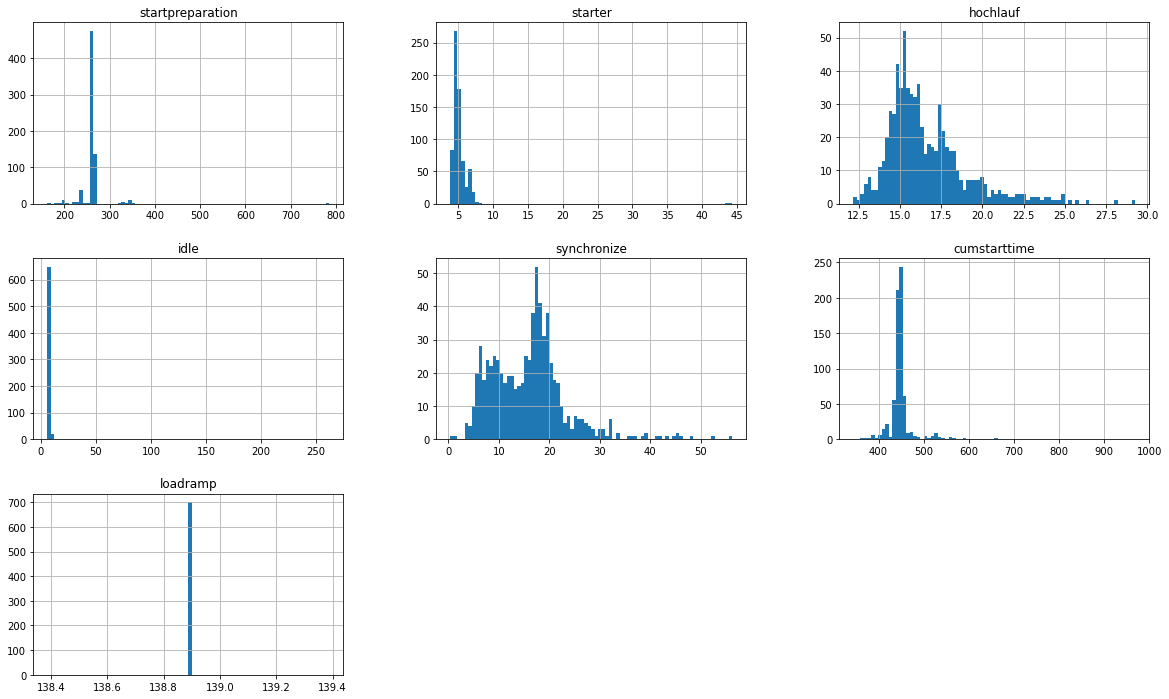

In [50]:
rda[['startpreparation','starter','hochlauf','idle','synchronize','cumstarttime','loadramp','targetoperation']].hist(figsize = (20,12), bins=80, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [ ]:
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7));
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7), sym='');

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 1
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            if ct2 >= mini and ct2 <= maxi:
                fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                plt.show()
            ct2 += 1

print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

In [ ]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
#fsm.store()